In [5]:
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Choose the model architecture
# Uncomment the one you want to use:
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='linear')(x)  # 7 regression outputs

# Define the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model summary
#model.summary()

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 1.4290 - mae: 0.9937 - val_loss: 1.0004 - val_mae: 0.8700 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 1.0179 - mae: 0.8674 - val_loss: 0.9964 - val_mae: 0.8679 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 1.0231 - mae: 0.8750 - val_loss: 0.9930 - val_mae: 0.8676 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 1.0389 - mae: 0.8848 - val_loss: 0.9939 - val_mae: 0.8680 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 1.0243 - mae: 0.8746 - val_loss: 0.9924 - val_mae: 0.8684 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 1.0022 - mae: 0.8647 - val_loss: 0.9935 - val_mae: 0.8680 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.9892 - mae: 0.8587 - val_loss: 0.9941 - val_mae: 0.8681 - learning_rate: 0.0010
Epoch 8/20
25/25 ━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.9966 - mae: 0.8715
Test Loss: 0.9923510551452637, Test MAE: 0.8683724999427795


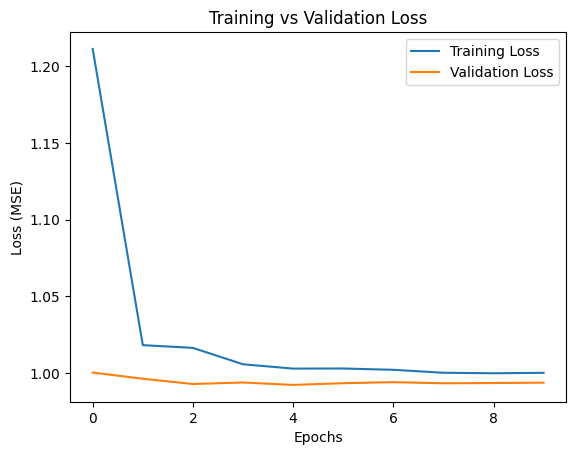

In [7]:
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

# Fine-tune the model
fine_tune_history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Plot fine-tuning training progress
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Fine-Tuning: Training vs Validation Loss')
plt.show()

Epoch 1/10


In [ ]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Reverse scaling for true and predicted values
y_test_original = scaler_y.inverse_transform(y_test)
y_pred_original = scaler_y.inverse_transform(y_pred)

# Visualize predictions
def visualize_predictions(X, y_true, y_pred, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(12, 5))

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("Input Image")

        # Show true vs predicted values
        plt.subplot(1, 2, 2)
        indices = range(len(y_true[i]))
        plt.bar(indices, y_true[i], alpha=0.6, label='True', color='blue')
        plt.bar(indices, y_pred[i], alpha=0.6, label='Predicted', color='orange')
        plt.xticks(indices, ['Calories', 'Proteins', 'Fat', 'Glucose', 'Cholesterol', 'Water', 'Energy'])
        plt.legend()
        plt.title("True vs Predicted Values")

        plt.show()

# Visualize predictions for test samples
visualize_predictions(X_test, y_test_original, y_pred_original)

In [ ]:
# let user input image path
image_path = input("Enter the path of the image: ")

# Preprocess the input image
original_image, preprocessed_image = preprocess_image(image_path)

# Predict nutritional values
predicted_values = model.predict(preprocessed_image)

# Nutritional value labels
nutritional_labels = ['calories', 'proteins', 'total_fat',
                       'glucose', 'cholesterol', 'water', 'Energy (Kcal)']

# Displaying the image and the predictions
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Display the image
ax[0].imshow(original_image)
ax[0].axis('off')
ax[0].set_title("Input Image")

# Display the predicted values
ax[1].axis('off')
ax[1].text(0.5, 0.8, "Predicted Nutritional Values", ha='center', va='center', fontsize=16, fontweight='bold')

# Display each label and value
for idx, (label, value) in enumerate(zip(nutritional_labels, predicted_values[0])):
    ax[1].text(0.5, 0.7 - (idx * 0.1), f"{label}: {value:.2f}", ha='center', va='center', fontsize=12)

plt.show()

# Bar plot of nutritional values
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(nutritional_labels, predicted_values[0], color='skyblue')

# Display the plot
plt.show()


In [ ]:
# Save the model
model.save("004_nutritional_value_model.h5")

In [ ]:
import numpy as np

# Define accuracy metric for regression
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    relative_error = np.abs((y_true - y_pred) / y_true)  # Relative error
    accurate_predictions = np.sum(relative_error <= tolerance)  # Predictions within tolerance
    accuracy = (accurate_predictions / len(y_true)) * 100  # Percentage accuracy
    return accuracy

y_train_pred_densenet = model.predict(X_train)
y_test_pred_densenet = .predict(X_test)

train_accuracy_densenet = regression_accuracy(y_train, y_train_pred_densenet)
test_accuracy_densenet = regression_accuracy(y_test, y_test_pred_densenet)
print(f"DenseNet121 - Train Accuracy: {train_accuracy_densenet:.2f}%, Test Accuracy: {test_accuracy_densenet:.2f}%")